## ⚙️ Configuración del Entorno

**Entorno Virtual:** Este proyecto usa un entorno virtual `.venv` con las dependencias instaladas.

**Paquetes necesarios:**
- gurobipy 12.0.3
- pandas, numpy, matplotlib, seaborn, scipy

---

# Inversión con Costos de Transacción

En este notebook exploramos cómo los **costos de transacción** afectan la composición óptima del portafolio. En la práctica, comprar o vender activos tiene costos asociados (comisiones, spreads, impuestos), lo que puede cambiar significativamente la estrategia óptima.

In [1]:
import gurobipy as gp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Datos de Entrada

Los siguientes datos de entrada se utilizan en el modelo:

- $S$: conjunto de acciones
- $\mu$: vector de rendimientos esperados
- $\Sigma$: matriz de varianza-covarianza
    - $\sigma_{ij}$ covarianza entre los rendimientos de los activos $i$ y $j$
    - $\sigma_{ii}$ varianza del rendimiento del activo $i$
- $c$: costo de transacción (como fracción del monto transado)

In [2]:
# Importar datos
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

# Portafolio inicial (supongamos que partimos con alguna inversión previa)
# Por ejemplo, distribución uniforme
x0 = pd.Series(index=mu.index, data=1.0/len(mu))

# Costo de transacción (como porcentaje)
# Ejemplo: 0.5% por transacción (compra o venta)
transaction_cost = 0.005

## Formulación con Costos de Transacción

El modelo maximiza el rendimiento esperado neto (descontando costos de transacción) para un nivel fijo de varianza (riesgo) preespecificado.

### Variables de Decisión

- $x_i$: proporción de capital invertido en la acción $i$ (portafolio objetivo)
- $x_i^0$: proporción de capital actualmente invertido en la acción $i$ (portafolio inicial)
- $y_i^+$: cantidad comprada del activo $i$ (variables auxiliares)
- $y_i^-$: cantidad vendida del activo $i$ (variables auxiliares)

Restricciones sobre las variables:
$$0 \leq x_i \leq 1, \quad y_i^+, y_i^- \geq 0$$

###  Restricciones

**1. Relación entre portafolio objetivo y transacciones:**
$$x_i = x_i^0 + y_i^+ - y_i^-, \quad \forall i \in S$$

**2. Restricción presupuestaria (considerando costos de transacción):**
$$\sum_{i \in S} x_i + c \sum_{i \in S} (y_i^+ + y_i^-) = 1$$

El segundo término representa el capital "perdido" en costos de transacción.

**3. Límite de riesgo:**
$$x^\top \Sigma x \leq \bar\sigma^2$$

###  Función Objetivo

Maximizar el rendimiento esperado neto:
$$\max_x \mu^\top x$$

Note que los costos ya están incorporados en la restricción presupuestaria.

In [3]:
V = 30  # varianza máxima admisible (sigma^2)

# Crear un modelo de optimización
m = gp.Model("Portfolio_TransactionCosts")

# Variables: x[i] = proporción final en activo i
x = m.addMVar(len(mu), lb=0, ub=1, name="x")

# Variables auxiliares: y_plus[i] = cantidad comprada, y_minus[i] = cantidad vendida
y_plus = m.addMVar(len(mu), lb=0, name="y_plus")
y_minus = m.addMVar(len(mu), lb=0, name="y_minus")

# Restricción: x = x0 + y_plus - y_minus
m.addConstr(x == x0.to_numpy() + y_plus - y_minus, name="Balance")

# Restricción presupuestaria con costos de transacción
m.addConstr(
    x.sum() + transaction_cost * (y_plus.sum() + y_minus.sum()) == 1,
    name="Budget_with_costs"
)

# Límite en la varianza
m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="Risk")

m.params.MIPGap = 0
m.params.NonConvex = 2

# Objetivo: Maximizar rendimiento esperado
m.setObjective(mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

Set parameter Username
Set parameter LicenseID to value 2670174
Academic license - for non-commercial use only - expires 2026-05-23
Set parameter LicenseID to value 2670174
Academic license - for non-commercial use only - expires 2026-05-23
Set parameter MIPGap to value 0
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0
Set parameter NonConvex to value 2


Resolvemos:

In [4]:
m.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
NonConvex  2

Optimize a model with 9 rows, 24 columns and 48 nonzeros
Model fingerprint: 0xa4486c35
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  QMatrix range    [2e-01, 2e+02]
  Objective range  [2e-01, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
  QRHS range       [3e+01, 3e+01]

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
NonConvex  2

Optimize a model with 9 rows, 24 columns and 48 nonzeros
Model fingerprint: 0xa4486c35
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  QMatrix range    [2e-01, 2e+02]
  Objective range  [2e-01, 3e+00]
  Bounds range     [1e+00, 1e+

## Resultados

In [5]:
print(f"Retorno esperado: {m.ObjVal:.4f}%")
print(f"Varianza:         {x.X @ Sigma @ x.X:.6f}")
print(f"Tiempo de solución: {m.Runtime:.2f} segundos\n")

# Calcular costos totales de transacción
total_traded = y_plus.X.sum() + y_minus.X.sum()
total_cost = transaction_cost * total_traded

print(f"Volumen total transado: {total_traded:.4f}")
print(f"Costo total de transacción: {total_cost:.4f} ({total_cost*100:.2f}%)\n")

# Mostrar cambios en el portafolio
portfolio_changes = pd.DataFrame({
    'Inicial': x0,
    'Final': x.X,
    'Compras': y_plus.X,
    'Ventas': y_minus.X,
    'Cambio Neto': x.X - x0
}, index=mu.index).round(6)

# Mostrar solo activos con cambios significativos
significant_changes = portfolio_changes[
    (np.abs(portfolio_changes['Cambio Neto']) > 1e-6) |
    (portfolio_changes['Compras'] > 1e-6) |
    (portfolio_changes['Ventas'] > 1e-6)
].sort_values('Cambio Neto', ascending=False)

print("\nCambios en el portafolio:")
print(significant_changes)

Retorno esperado: 2.4889%
Varianza:         29.999963
Tiempo de solución: 0.02 segundos

Volumen total transado: 1.4926
Costo total de transacción: 0.0075 (0.75%)


Cambios en el portafolio:
                      Inicial     Final   Compras    Ventas  Cambio Neto
OXIQUIM Cierre Ix       0.125  0.639568  0.514571  0.000003     0.514568
CEMENTOS Cierre Ix      0.125  0.352969  0.227972  0.000003     0.227969
AFPCAPITAL Cierre Ix    0.125  0.000000  0.000005  0.125005    -0.125000
CONCHATORO Cierre Ix    0.125  0.000000  0.000008  0.125008    -0.125000
ENERSIS-AM Cierre Ix    0.125  0.000000  0.000008  0.125008    -0.125000
INVERCAP Cierre Ix      0.125  0.000000  0.000008  0.125008    -0.125000
MELON Cierre Ix         0.125  0.000000  0.000006  0.125006    -0.125000
SONDA Cierre Ix         0.125  0.000000  0.000007  0.125007    -0.125000


## Comparación: Con vs Sin Costos de Transacción

Ahora resolveremos el mismo problema **sin** costos de transacción para comparar.

In [6]:
# Modelo SIN costos de transacción
m_no_cost = gp.Model("Portfolio_NoCosts")
m_no_cost.params.OutputFlag = 0
m_no_cost.params.MIPGap = 0
m_no_cost.params.NonConvex = 2

x_no_cost = m_no_cost.addMVar(len(mu), lb=0, ub=1, name="x")

# Restricción presupuestaria simple (sin costos)
m_no_cost.addConstr(x_no_cost.sum() == 1, name="Budget")

# Límite en la varianza
m_no_cost.addConstr(x_no_cost @ Sigma.to_numpy() @ x_no_cost <= V, name="Risk")

# Objetivo: Maximizar rendimiento esperado
m_no_cost.setObjective(mu.to_numpy() @ x_no_cost, gp.GRB.MAXIMIZE)

m_no_cost.optimize()

print(f"\n=== Modelo SIN costos de transacción ===")
print(f"Retorno esperado: {m_no_cost.ObjVal:.4f}%")
print(f"Varianza: {x_no_cost.X @ Sigma @ x_no_cost.X:.6f}")


=== Modelo SIN costos de transacción ===
Retorno esperado: 2.5061%
Varianza: 29.999919


### Visualización Comparativa

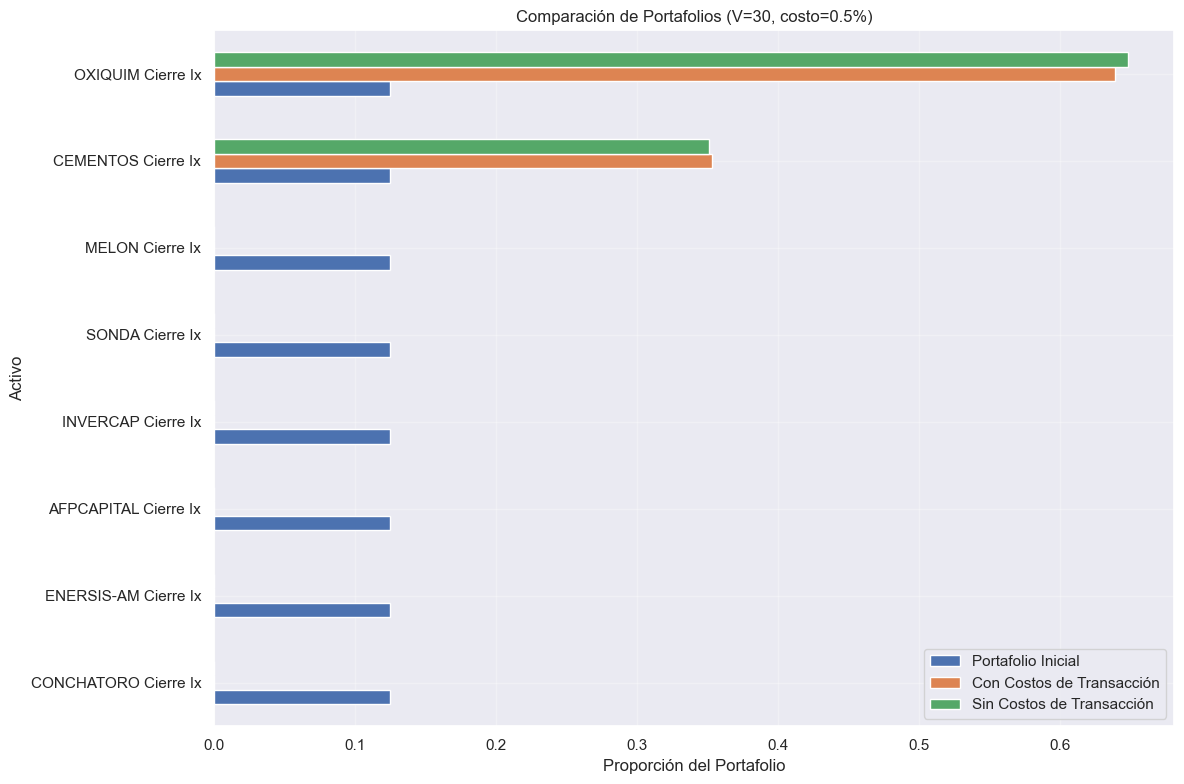

In [7]:
# Crear DataFrame para comparación
comparison = pd.DataFrame({
    'Portafolio Inicial': x0,
    'Con Costos de Transacción': x.X,
    'Sin Costos de Transacción': x_no_cost.X
}, index=mu.index)

# Filtrar activos con al menos una posición significativa
mask = (
    (comparison['Portafolio Inicial'] > 1e-6) |
    (comparison['Con Costos de Transacción'] > 1e-6) |
    (comparison['Sin Costos de Transacción'] > 1e-6)
)
comparison_filtered = comparison[mask].sort_values(
    'Sin Costos de Transacción', ascending=True
)

# Graficar
fig, ax = plt.subplots(figsize=(12, 8))
comparison_filtered.plot.barh(ax=ax)
ax.set_xlabel('Proporción del Portafolio')
ax.set_ylabel('Activo')
ax.set_title(f'Comparación de Portafolios (V={V}, costo={transaction_cost*100:.1f}%)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Análisis de Sensibilidad: Efecto del Costo de Transacción

Vamos a explorar cómo diferentes niveles de costos de transacción afectan:
1. El retorno esperado del portafolio
2. El volumen de transacciones realizadas
3. La composición del portafolio

In [9]:
# Probar diferentes niveles de costos de transacción
cost_levels = np.linspace(0, 0.02, 20)  # De 0% a 2%

results = {
    'cost': [],
    'return': [],
    'volume': [],
    'total_cost': [],
    'n_trades': []  # número de activos con transacciones
}

print("Calculando sensibilidad a costos de transacción...")

for i, c in enumerate(cost_levels):
    # Crear modelo
    m_temp = gp.Model()
    m_temp.params.OutputFlag = 0
    m_temp.params.MIPGap = 0
    m_temp.params.NonConvex = 2
    
    x_temp = m_temp.addMVar(len(mu), lb=0, ub=1, name="x")
    y_plus_temp = m_temp.addMVar(len(mu), lb=0, name="y_plus")
    y_minus_temp = m_temp.addMVar(len(mu), lb=0, name="y_minus")
    
    m_temp.addConstr(x_temp == x0.to_numpy() + y_plus_temp - y_minus_temp)
    m_temp.addConstr(x_temp.sum() + c * (y_plus_temp.sum() + y_minus_temp.sum()) == 1)
    m_temp.addConstr(x_temp @ Sigma.to_numpy() @ x_temp <= V)
    m_temp.setObjective(mu.to_numpy() @ x_temp, gp.GRB.MAXIMIZE)
    
    m_temp.optimize()
    
    if m_temp.Status == gp.GRB.OPTIMAL:
        volume = y_plus_temp.X.sum() + y_minus_temp.X.sum()
        n_trades = np.sum((y_plus_temp.X > 1e-6) | (y_minus_temp.X > 1e-6))
        
        results['cost'].append(c * 100)  # Convertir a porcentaje
        results['return'].append(m_temp.ObjVal)
        results['volume'].append(volume)
        results['total_cost'].append(c * volume * 100)
        results['n_trades'].append(n_trades)
    
    if (i + 1) % 5 == 0:
        print(f"  Progreso: {i+1}/{len(cost_levels)}")

print("✓ Análisis completado.")

Calculando sensibilidad a costos de transacción...
  Progreso: 5/20
  Progreso: 10/20
  Progreso: 15/20
  Progreso: 20/20
✓ Análisis completado.


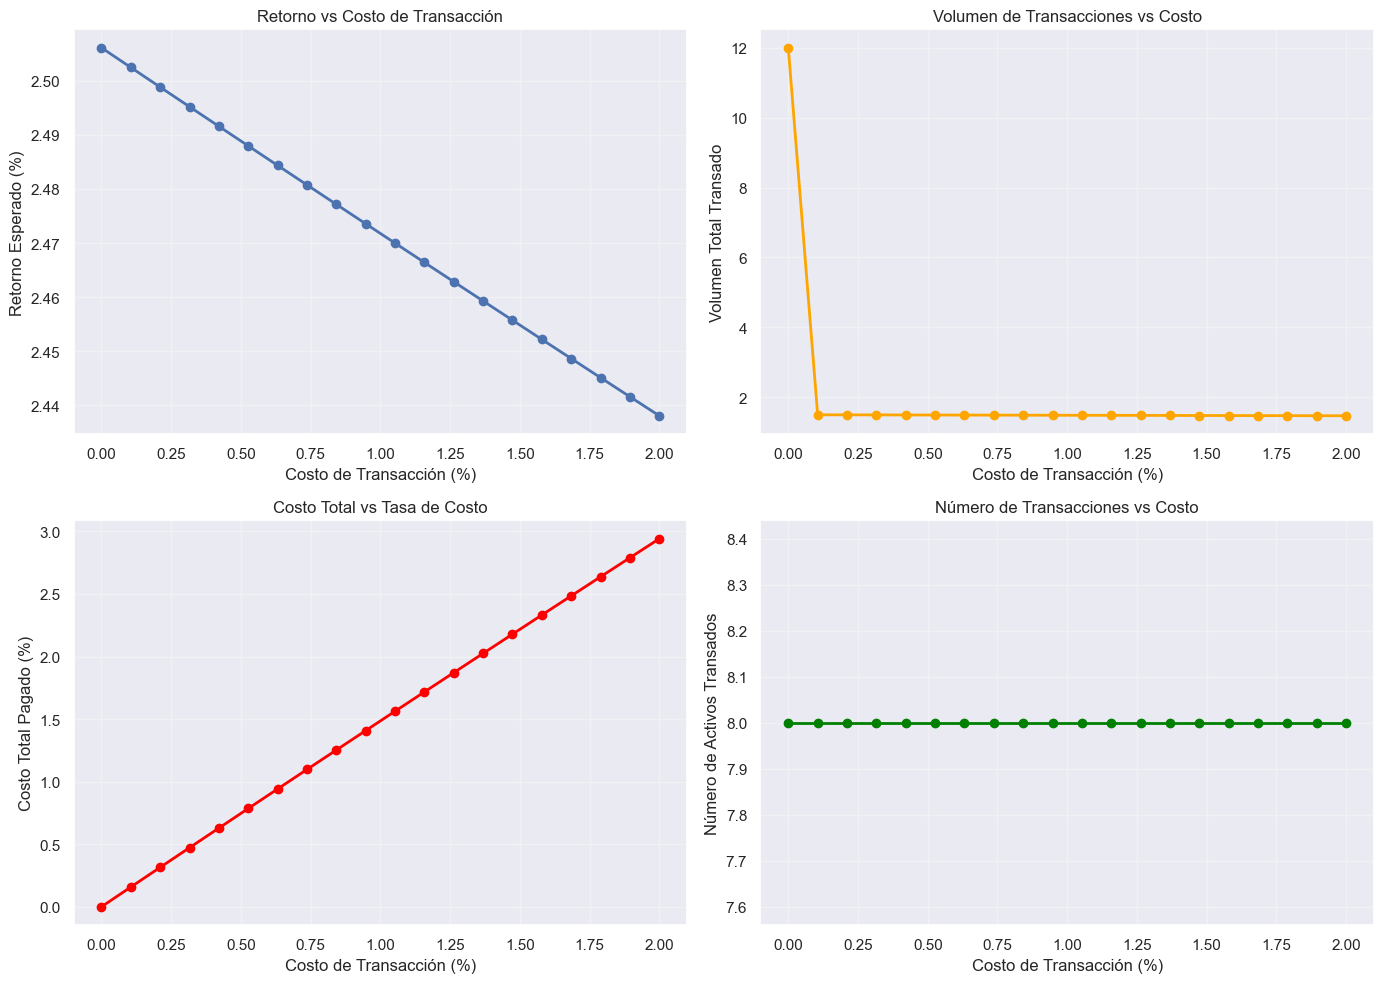

In [10]:
# Visualizar resultados del análisis de sensibilidad
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Retorno esperado vs costo de transacción
axes[0, 0].plot(results['cost'], results['return'], 'o-', linewidth=2)
axes[0, 0].set_xlabel('Costo de Transacción (%)')
axes[0, 0].set_ylabel('Retorno Esperado (%)')
axes[0, 0].set_title('Retorno vs Costo de Transacción')
axes[0, 0].grid(True, alpha=0.3)

# 2. Volumen transado vs costo de transacción
axes[0, 1].plot(results['cost'], results['volume'], 'o-', color='orange', linewidth=2)
axes[0, 1].set_xlabel('Costo de Transacción (%)')
axes[0, 1].set_ylabel('Volumen Total Transado')
axes[0, 1].set_title('Volumen de Transacciones vs Costo')
axes[0, 1].grid(True, alpha=0.3)

# 3. Costo total pagado vs costo de transacción
axes[1, 0].plot(results['cost'], results['total_cost'], 'o-', color='red', linewidth=2)
axes[1, 0].set_xlabel('Costo de Transacción (%)')
axes[1, 0].set_ylabel('Costo Total Pagado (%)')
axes[1, 0].set_title('Costo Total vs Tasa de Costo')
axes[1, 0].grid(True, alpha=0.3)

# 4. Número de transacciones vs costo
axes[1, 1].plot(results['cost'], results['n_trades'], 'o-', color='green', linewidth=2)
axes[1, 1].set_xlabel('Costo de Transacción (%)')
axes[1, 1].set_ylabel('Número de Activos Transados')
axes[1, 1].set_title('Número de Transacciones vs Costo')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusiones

Del análisis anterior, podemos observar:

1. **Efecto sobre el Retorno**: A mayor costo de transacción, menor es el retorno esperado neto del portafolio, ya que parte del capital se pierde en costos.

2. **Reducción de Transacciones**: Costos más altos incentivan a mantener posiciones más cercanas al portafolio inicial, reduciendo el volumen transado.

3. **Trade-off**: Existe un equilibrio entre el beneficio de rebalancear el portafolio hacia la composición óptima y el costo de realizar esas transacciones.

4. **Inercia del Portafolio**: Con costos de transacción suficientemente altos, puede ser óptimo NO hacer ningún cambio al portafolio inicial, incluso si este no es el portafolio óptimo teórico.

Este modelo es particularmente relevante para:
- Rebalanceo periódico de portafolios
- Trading algorítmico con spreads bid-ask
- Inversiones con comisiones de corretaje
- Mercados con impuestos a las transacciones